<center> 

# **CASE STUDY: TTC STREETCAR DELAY - A DATA SCIENCE APPROACH**

***TABLE OF CONTENT:***

*I - DATA COLLECTION & ELT* (by Jay Menarco)

*II - DATA PRE-PROCESSING / FEATURE ENGINEERING* (by Ly Nguyen)

*III - ANALYSIS* (by Ly Nguyen) 

*- Hyperparameter Tuning*

*- Random Forest Classification* 

*- Model Evaluation*
    

*IV - INSIGHTS & DATA VISUALIZATION* (by XiaoXiao, Ly Nguyen )
 
*V - CONCLUSION* (by XiaoXiao)

</center>

<center>

# **I - DATA COLLECTION / ELT** 
By: Jay Menarco.

</center>

**PRELIMINARY STEP: GITHUB REPOSITORY SETUP:**

- Github repository: jays-codes/team24
- Description: Main branch, developent branch, and release branch. 
- Each team member forked the repository (all branches), and worked (push/pull changes) on the development branch.

**DATA COLLECTION / ETL**

- Performed ETL (Extract, Load, Transform): 
    - Extracted the following dataset, saved to SQLite database and Github repo: 
        - TTC Streetcar Delay, FY2023 and YTD-09-2024 (https://open.toronto.ca/dataset/ttc-streetcar-delay-data/): directly extracted to Github. 
    
    - Created the following datasets, saved to SQLite database and/or Python dataframes and Github repository:  
        - Ontario Public Holiday, 2023 and 2024 (https://excelnotes.com/holidays-ontario-2023/ and https://excelnotes.com/holidays-ontario-2024): no file available, only information online. We manually created the datasets in .csv and saved to Github. 
        - Line route (https://www.ttc.ca/routes-and-schedules/listroutes/streetcar): no file available, only information online. We manually created the datasets in .csv and saved to Github.  
    
    - Loaded: 
        - Loaded the data to SQLite database 
        - From SQLite database, loaded to Python Panda dataframe. 
   
    - Transformed: 
        - Joined datasets to prepare for analysis: 
        - Performed some feature-engineering to prepare for analysis 
   


# *DATA COLLECTION & ELT*

In [2]:
#Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd


**LOADING**

In [3]:
# Function to load data from SQLite database
def load_from_db(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, conn)
    conn.close()

    return df

In [4]:

# Check if __file__ is defined
if '__file__' in globals():
    # Get the directory two levels up from the current script
    base_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))
else:
    # Fallback for environments where __file__ is not defined
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    
    # Construct the relative path to the database
db_name = os.path.join(base_dir, 'data', 'streetcardelaydb.db')
table_name = 'Streetcar_Delay_Data'  # Replace with your table name

# Check if the database file exists
if not os.path.exists(db_name):
    raise FileNotFoundError(f"Database file not found: {db_name}")

# Load data from SQLite database
df = load_from_db(db_name, table_name)




**TRANSFORMING**

In [5]:
# Convert Incident_Date to datetime
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Load Date table to get isHoliday, isWeekend, and isEndOfMth columns
date_table_name = 'Date'  # Replace with your date table name
date_df = load_from_db(db_name, date_table_name)
date_df['date'] = pd.to_datetime(date_df['date'])

# Merge Date table with Streetcar_Delay_Data table on incident_date
df = df.merge(date_df[['date', 'isHoliday', 'isWeekend', 'isEndOfMth']], left_on='incident_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)


# Load Line table to get lineType
line_table_name = 'Line'  # Replace with your line table name
line_df = load_from_db(db_name, line_table_name)

# Merge the dataframes on lineId
df = df.merge(line_df[['lineId', 'lineType']], left_on='line', right_on='lineId', how='left')

#for lineType that has not been set, set it to 4
df['lineType'] = df['lineType'].fillna(4)

# Load Delay table to get delayType
delay_table_name = 'Delay'  # Replace with your delay table name
delay_df = load_from_db(db_name, delay_table_name)

# Function to determine delayType
def get_delay_type(min_delay):
    for _, row in delay_df.iterrows():
        if row['delayFrom'] <= min_delay <= row['delayTo']:
            return row['delayId']
    return None

# Apply the function to determine delayType
df['delayType'] = df['min_delay'].apply(get_delay_type)

# Display the DataFrame
df.head()

,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,isHoliday,isWeekend,isEndOfMth,lineId,lineType,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,1,1,0,505,2.0,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,1,1,0,504,2.0,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,1,1,0,504,2.0,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,1,1,0,510,2.0,2
4,2023-01-01,506,06:35,Sunday,OSSINGTON STATION,Security,10,20,None,8706,1,1,0,506,2.0,2


<center>

# **DATA PRE-PROCESSING / FEATURE ENGINEERING** 

By: Ly Nguyen 

</center>

**- Exploratory data analysis**

- Assess min, max, quantiles, standard deviations of features
- Assess class imbalance
- Assess outliers 

**- Data Pre-processing:**

- Handle any NULL values, NA values, and zeros. 

- Select the response variable and the predictors:
    - Predictors:
        - Day (7 categories: Monday -> Sunday)

        - Holiday (2 categories: Yes / No)

        - Time (4 categories: peak morning, peak afternoon, peak evening, others)

        - Line (4 categories: regular, special, night, others (ie. bus substitute))

        - Location (~3,000 unique locations)

        - Bound (4 categories: N, S, W, E)

        - Vehicle (~2,000 unique vehicles)

        - Incident category (13 categories)


    - Response variable:
        - Delay time (3 categories: short delay, expected delay, long delay) 

- Use Statistical Inference with visualization tools: 

    - Handle significant outliers 
    
- Feature engineering:
    - Create new 'feature_id' columns - to be used for machine learning models. 
    
    - Note: For this project, we explore using Random Forest Classifier - which can handle 'text string' values well and therefore doesn't need to be converted to numerical values datatype. However, there is a sustainable benefit in converting them to numerical datatype as they can be used for other machine learning models - if we shall want to do so in the future.
    

# *EXPLORATORY ANALYSIS*


In [6]:
# Display exploratory statistics
df.describe()

,incident_date,min_delay,min_gap,isHoliday,isWeekend,isEndOfMth,lineType,delayType
count,21742,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000,21742.000000
mean,2023-11-17 14:32:47.730659584,18.185494,27.249885,0.027504,0.282771,0.032978,2.017708,2.133014
min,2023-01-01 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,2023-11-24 00:00:00,10.000000,20.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,2024-04-15 00:00:00,15.000000,24.000000,0.000000,1.000000,0.000000,2.000000,2.000000
max,2024-09-30 00:00:00,960.000000,968.000000,1.000000,1.000000,1.000000,4.000000,3.000000
std,NaN,37.272247,39.340414,0.163552,0.450356,0.178582,0.261982,0.561122


**Observation:**

- Count of observations: > 20,000 observations in our dataset - which is sufficient. 
- Delay time: 
    - The statistical distribution appears to be skewed to the right.
    - The majority of delay is **within** 15 minutes value (960) and large standard deviation (37) - in comparison to mean (18) and 75% quantile (15). 
- We choose Delay time ('min_delay') as the response variable as it is a more meaningful variable to interpret than Gap time ('min_gap').
- The rest of our features to be chosen looks okay.


In [7]:
# Assess datatype and any NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  21742 non-null  datetime64[ns]
 1   line           21698 non-null  object        
 2   incident_time  21742 non-null  object        
 3   day_of_week    21742 non-null  object        
 4   location       21741 non-null  object        
 5   incident       21742 non-null  object        
 6   min_delay      21742 non-null  int64         
 7   min_gap        21742 non-null  int64         
 8   bound          19127 non-null  object        
 9   vehicle        21742 non-null  object        
 10  isHoliday      21742 non-null  int64         
 11  isWeekend      21742 non-null  int64         
 12  isEndOfMth     21742 non-null  int64         
 13  lineId         21574 non-null  object        
 14  lineType       21742 non-null  float64       
 15  delayType      2174

**Observation:**
    
- We have >20,000 observations, and <2,000 NULL values. So, we can remove NULL values without significant impact.

In [8]:
# Count the unique values of each of the features
df.nunique()

incident_date     639
line               44
incident_time    1439
day_of_week         7
location         3197
incident           14
min_delay         268
min_gap           292
bound               8
vehicle          1578
isHoliday           2
isWeekend           2
isEndOfMth          2
lineId             16
lineType            4
delayType           3
dtype: int64

**Observation:**
- The 'bound' variable shows 8 unique values - which is wrong. It should be 4 ('N' North, 'S' South, 'W' West, 'E' East). 
- The rest looks okay.

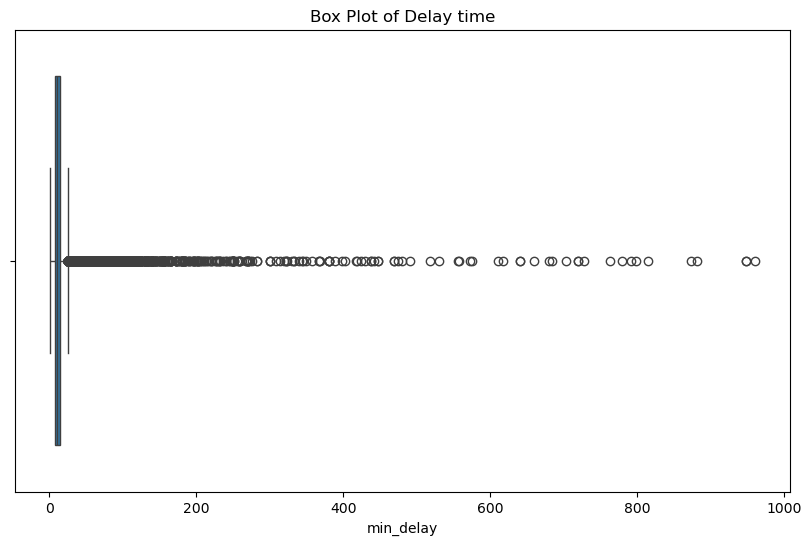

In [9]:
# Check for class imbalance with data visualization tools.

# Import libraries for data visualization to graph whisker plot, influence plot, and histogram. 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['min_delay'])
plt.title('Box Plot of Delay time')
plt.show()

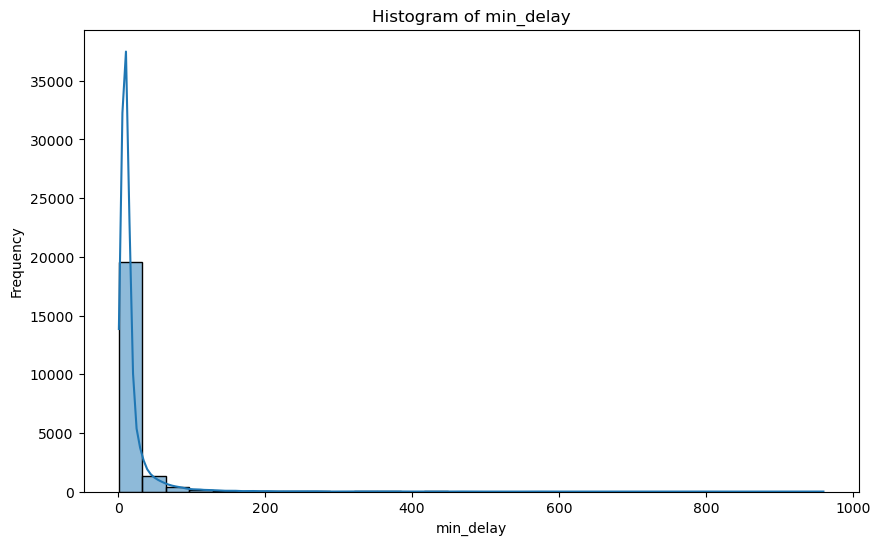

In [10]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()

**Observation:**

- Most of the Delay time observations fall within 15 minutes (the boxplot)
- A lot of outliers outside of 15 minutes, extending as far as 900s minutes. 
- Data Distribution is skewed to the right. 
- We have several options to approach this case study: 
    - Option 1: Focus the analysis on the most frequently encountered delays - ie. within 15 minutes delay. 
    - Option 2: Focus the analysis on the most disruptive and significant delays - ie. above 600s minutes. 
    - Option 3: Include all data points to have a general view, and accept the possibility of a less accurate prediction. 

**Approach:**

- For this project scope, we choose **Option 3: to have a general view, accepting the possibility of a less accurate prediction**. 

- We try to minimize inaccuracies as much as possible for Option 3, by using a Classifier, defining classes of 'frequent delays' and 'disruptive/significant delays', and Random Forest Classifier as it is generally robust with outliers. 
    - Class 1 - Short delay time: <= 5 minutes delay 
    - Class 2 - Expected delay time: between 6 - 15 minutes delay 
    - Class 3 - Long delay time: over 15 minutes delay. 

- (Remark: Option 1 and Option 2 are *out of scope* but can be studied separately in the future.)


# *DATA PRE-PROCESSING / FEATURE ENGINEERING*

In [11]:
# Convert incident_time to datetime
df['incident_time'] = pd.to_datetime(df['incident_time'], format='%H:%M').dt.time

# Define function to categorize time
def categorize_time(time):
    if time >= pd.to_datetime('06:30').time() and time <= pd.to_datetime('09:30').time():
        return 1
    elif time >= pd.to_datetime('10:00').time() and time <= pd.to_datetime('14:00').time():
        return 2
    elif time >= pd.to_datetime('16:30').time() and time <= pd.to_datetime('19:00').time():
        return 3
    else:
        return 4

# Apply function to create new column "timeType"
df['timeType'] = df['incident_time'].apply(categorize_time)


# Clean and factorize columns: location, bound, incident, vehicle, day_of_week
# Define a helper function
def clean_and_factorize(df, column_name, valid_values=None):
    # Remove leading and trailing spaces
    df[column_name] = df[column_name].str.strip()
    
    # Drop null values
    df = df.dropna(subset=[column_name])
    
    # If valid values are provided, filter the dataframe
    if valid_values:
        df = df[df[column_name].isin(valid_values)]
    
    # Assign unique numeric values
    df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1
    
    return df

# Apply the function to each column
df = clean_and_factorize(df, 'location')
df = clean_and_factorize(df, 'incident')
df = clean_and_factorize(df, 'vehicle')
df = clean_and_factorize(df, 'day_of_week')
df = clean_and_factorize(df, 'line')
df = clean_and_factorize(df, 'bound', valid_values=['N', 'S', 'W', 'E'])


# Display the DataFrame
df.head()


C:\Users\Xiaoxiao\AppData\Local\Temp\ipykernel_23824\714986131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1
C:\Users\Xiaoxiao\AppData\Local\Temp\ipykernel_23824\714986131.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column_name}_id"] = pd.factorize(df[column_name])[0] + 1


,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,...,lineId,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
0,2023-01-01,505,02:40:00,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,...,505,2.0,2,4,1,1,1,1,1,1
1,2023-01-01,504,02:52:00,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,...,504,2.0,2,4,2,2,2,1,2,1
2,2023-01-01,504,02:59:00,Sunday,KING AND BATHURST,Held By,25,35,E,4560,...,504,2.0,3,4,2,1,3,1,2,2
3,2023-01-01,510,05:38:00,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,...,510,2.0,2,4,3,3,4,1,3,3
5,2023-01-01,501,08:52:00,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,...,501,2.0,2,1,5,2,6,1,5,1


In [12]:
# Verify that there are 4 'bound' unique values: 
df.nunique()

incident_date      639
line                42
incident_time     1438
day_of_week          7
location          2936
incident            14
min_delay          246
min_gap            268
bound                4
vehicle           1537
isHoliday            2
isWeekend            2
isEndOfMth           2
lineId              16
lineType             4
delayType            3
timeType             4
location_id       2936
incident_id         14
vehicle_id        1537
day_of_week_id       7
line_id             42
bound_id             4
dtype: int64

In [13]:
# Verify that the NULL objects have been dropped. 
null_counts = df.isnull().sum()
print(null_counts)

incident_date       0
line                0
incident_time       0
day_of_week         0
location            0
incident            0
min_delay           0
min_gap             0
bound               0
vehicle             0
isHoliday           0
isWeekend           0
isEndOfMth          0
lineId            104
lineType            0
delayType           0
timeType            0
location_id         0
incident_id         0
vehicle_id          0
day_of_week_id      0
line_id             0
bound_id            0
dtype: int64


**Comment:** 
- The "lineId" column was created as primary key to join tables only. We can drop this, along with other non-beneficial predictors - see codes below.

In [14]:
# Drop null values in 'lineId'
df = df.dropna(subset=['lineId'])

# Drop the following columns: incident_date, incident_time, min_gap, isEndOfMth, lineID. min_delay
df_cleaned = df.drop(['incident_date','incident_time', 'min_gap', 'isEndOfMth', 'lineId'], axis=1)

# Verify the columns are dropped
df_cleaned.head()

,line,day_of_week,location,incident,min_delay,bound,vehicle,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
0,505,Sunday,BROADVIEW AND GERRARD,Held By,15,W,4460,1,1,2.0,2,4,1,1,1,1,1,1
1,504,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,W,4427,1,1,2.0,2,4,2,2,2,1,2,1
2,504,Sunday,KING AND BATHURST,Held By,25,E,4560,1,1,2.0,3,4,2,1,3,1,2,2
3,510,Sunday,SPADINA AND DUNDAS,Security,15,S,4449,1,1,2.0,2,4,3,3,4,1,3,3
5,501,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,W,8015,1,1,2.0,2,1,5,2,6,1,5,1


**Note:**
- The unique ids columns (ie. location_id, vehicle_id, etc.) will be used in the predicitve models. 
- We are keeping names of predictors (e.g., line, day_of_week, etc) to re-map them to their unique ids later during the data visualization.

In [15]:
# Reviewing the data types and counts to make sure everything looks okay.
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18979 entries, 0 to 21741
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   line            18979 non-null  object 
 1   day_of_week     18979 non-null  object 
 2   location        18979 non-null  object 
 3   incident        18979 non-null  object 
 4   min_delay       18979 non-null  int64  
 5   bound           18979 non-null  object 
 6   vehicle         18979 non-null  object 
 7   isHoliday       18979 non-null  int64  
 8   isWeekend       18979 non-null  int64  
 9   lineType        18979 non-null  float64
 10  delayType       18979 non-null  int64  
 11  timeType        18979 non-null  int64  
 12  location_id     18979 non-null  int64  
 13  incident_id     18979 non-null  int64  
 14  vehicle_id      18979 non-null  int64  
 15  day_of_week_id  18979 non-null  int64  
 16  line_id         18979 non-null  int64  
 17  bound_id        18979 non-null  int6

In [16]:
# Reviewing the dataframe to make sure everything looks okay. 
df_cleaned.describe()

,min_delay,isHoliday,isWeekend,lineType,delayType,timeType,location_id,incident_id,vehicle_id,day_of_week_id,line_id,bound_id
count,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000,18979.000000
mean,17.633542,0.027030,0.282259,2.002371,2.122557,3.136625,565.652932,5.542494,336.286475,4.083619,4.830497,1.998314
std,35.667862,0.162175,0.450111,0.192998,0.558937,1.091569,724.594081,2.967546,354.037560,1.990338,4.377895,1.003785
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,0.000000,0.000000,2.000000,2.000000,2.000000,90.000000,3.000000,98.000000,2.000000,2.000000,1.000000
50%,10.000000,0.000000,0.000000,2.000000,2.000000,4.000000,247.000000,5.000000,209.000000,4.000000,4.000000,2.000000
75%,14.000000,0.000000,1.000000,2.000000,2.000000,4.000000,703.000000,8.000000,402.000000,6.000000,5.000000,2.500000
max,960.000000,1.000000,1.000000,3.000000,3.000000,4.000000,3197.000000,14.000000,1578.000000,7.000000,41.000000,4.000000


# *ASSESSING FOR ANY CLASS IMBALANCE*

In [17]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

delayType
2    12765
3     4270
1     1944
Name: count, dtype: int64


C:\Users\Xiaoxiao\AppData\Local\Temp\ipykernel_23824\2728593396.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')


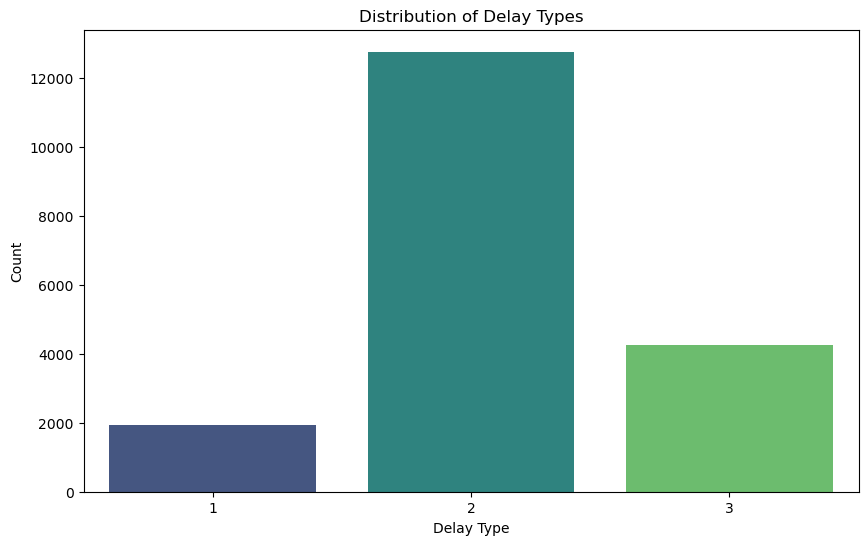

In [18]:
# Visualize this with a whisker plot:
delay_type_counts = df_cleaned['delayType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')
plt.title('Distribution of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Count')
plt.show()


**Observation:**
- delayType 1 (Short Delay Time - within 5 minutes): 1,953 observations. 
- delayType 2 (Expected Delay Time - between 6 and 15 minutes): 12,829 observations. **This class significantly dominates the dataset.**
- delayType 3 (Long Delay Time - over 15 minutes): 4,301 observations. 

<center>

# **ANALYSIS**
by: Ly Nguyen

<center>

# *PREDICTIVE METHOD: RANDOM FOREST CLASSIFIER* 

**SETTING TRAINING & TEST SETS** 

In [19]:
# Import panda and ML Random Forest Classifier libraries 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Convert the delayType to numerical values
df_cleaned['delayType_id'] = pd.factorize(df_cleaned['delayType'])[0]

# Split data into features (X) and target (y)
X = df_cleaned[['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id', 'bound_id', 
                'isHoliday', 'isWeekend', 'lineType', 'timeType']]
y = df_cleaned['delayType_id']

# Set random seed for reproducibility
random_seed = 42

# Split the data into training set (80%) and test set (20%) where the training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)




# *HYPERPARAMETER TUNING - FINDING OPTIMAL ML PARAMETERS*

In [20]:
# Import the GridSearch Cross-Validator library
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200], # testing different numbers of trees in the forest: 50 trees, 100 trees, 200 trees. 
    'max_depth': [None, 10, 20, 30], # preventing overfitting by limiting how deep the trees can grow: max 10 levels, 20 levels, 30 levels. 
    'min_samples_split': [2, 5, 10], # further reducing overfitting, by controlling the growth of the trees, by specifying the minimum number of samples required to split an internal node: allowing split even if only 2 samples are present, 5 samples are present, 10 samples are present. 
    'min_samples_leaf': [1, 2, 4] # further reducing overfitting, by controlling the size of the tree, by determining the minimum number of samples required to be at a leaf node: allowing leaves to contain 1 sample, 2 samples, 4 samples. 
}


In [21]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
                    estimator=clf, # select "clf" (Random Forest Classifier - defined above) as the estimator. 
                    param_grid=param_grid, # defines the hyperparameters (defined in the cell above) and their possible values to be searched over. 
                    cv=5, # specifies the number of cross-validation folds to be used: 5. Ie. Split the data into 5 subsets, each taking turn as training set and validation set. The process is repeated 5 tiems. 
                    scoring='accuracy', # specifies the metric "accuracy" as the scoring metric to evaluate the model's performance. Accuracy is the ratio of correctly predicted instances to the total instances.
                    n_jobs=-1) # tells GridSearchCV to use all available CPU cores for computation, speeding up the computation process.

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [43]:
best_params = {
    'n_estimators': 100,  # Number of trees in the forest
    'min_samples_leaf': 2,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 10  # Minimum number of samples required to split an internal node
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       random_state=42)

# *RANDOM FOREST CLASSIFIER - WITH THE OPTIMAL PARAMETERS*

In [44]:
# Import the Random Forest Classifier library
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the Random Forest Classifier with best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

clf.fit(X_train, y_train)

# Predicting the delay types
y_pred = clf.predict(X_test)

# Get feature importances
feature_importances = best_clf.feature_importances_
features = ['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id', 'bound_id', 
    'isHoliday', 'isWeekend', 'lineType', 'timeType'
    ]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

          Feature  Importance
1     incident_id    0.250129
2      vehicle_id    0.240201
0     location_id    0.189223
4         line_id    0.127006
3  day_of_week_id    0.068362
5        bound_id    0.046071
9        timeType    0.039764
8        lineType    0.017531
7       isWeekend    0.016410
6       isHoliday    0.005303


**Interpretation:**
The most likely predictors for delay types (short, expected, long delays) are **incident type (25%), vehicle (24%), location (19%) and line (13%)**. Other features play little influence.
With this insight, we can further analyze which values of these 4 features most likely predict which delay type - in the Insights section to follow using Heatmap plots.

# *MODEL PERFORMANCE EVALUATION*

**Note:** The order of class labels (0, 1, 2) in sklearn’s classification report aligns with the order they are sorted in the dataframe's value_counts() output. So, let's do the value_counts() to see the mapping. 

In [45]:
# Double-check the class order that sklearn outputs, as it aligns with the order the are sorted in the dataframe's value_counts() output.
print(df_cleaned['delayType'].value_counts())

delayType
2    12765
3     4270
1     1944
Name: count, dtype: int64


**Observation:** 

The order is: 

- **Class 0** maps to **delayType 2 (Expected Delay Time: 6-15 minutes)**
- **Class 1** maps to **delayType 3 (Long Delay Time: >15 minutes)**
- **Class 2** maps to **delayType 1 (Short Delay Time: <= 5 minutes)**

# 1) Accuracy, Precision, Recall and F1 Score

In [46]:
# Import the Classification Evaluator library
from sklearn.metrics import classification_report

# Run the evaluation on the model's performance with custom labels
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82      2559
           1       0.60      0.39      0.47       863
           2       0.66      0.26      0.38       374

    accuracy                           0.72      3796
   macro avg       0.67      0.52      0.56      3796
weighted avg       0.71      0.72      0.70      3796



**INTERPRETATION:**

- **Accuracy:** **72%** of the predictions made by the model are correct.

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    - **Class 0** (delayType 2 - Expected Delay Time: 6-15 minutes): This class **performs well** with high scores across precision, recall, and f1 (75%, 91%, 82%). 
       
    - **Class 1** (delayType 3 - Long Delay Time: over 15 minutes ): This class **performs poorly** on the recall score (39%), with many actual Class 1 instances are not being predicted as Class 1. 

    - **Class 2** (delayType 1 - Short Delay Time: <=5 minutes): This class **performs poorly** on the recall score (26%), with many actual Class 2 instances are not being predicted as Class 2. 



# 2) Evaluation - Comment:

Our predictive model gives acceptable performance on the accuracy score (72%) with 72% of the predictions made by this model are correct. 

The model also performs well for Class 0 (delayType 2 - Expected Delay Time: 6-15 minutes) across precision (75%), recall (91%) and F1 scores (82%). This class also significantly dominates the dataset. 

With these acceptable scores, we can rely on this model to achieve our business objective which is to find the most likely predictors of delay times, especially for Class 0 which is the most frequently encountered delay type (delay between 6-15 minutes). 

For future studies, we recommend further analysis into other delay types for a more accurate understanding of most likely predictors, and therefore for pre-emptive actions. 



    

<center>

# **INSIGHTS & DATA VISUALIZATION** 

By: Xiaoxiao Gong, Ly Nguyen




  - **Purpose**: The visualizations were conducted to gain deeper insights from the TTC streetcar delay data and help in identifying key patterns contributing to delays.
  - **Heatmaps**:
    - Generated multiple heatmaps to explore the **distribution of delay types** across various features such as `incident`, `vehicle`, `line`, and `location`. 
    - These heatmaps effectively highlighted which categories are more prone to different types of delays, providing insights for further targeted analysis.
  - **Bar Plot**:
    - Created a bar chart depicting the **most dominant incidents for 'Expected Delay Time'** (6-15 minutes). This visualization showed which types of incidents are the primary contributors to moderate delays.
  - **Feature Importance Chart**:
    - Developed a feature importance chart based on the **Random Forest Classifier** results, indicating which features significantly influence the model's predictions.
    - Key features such as `incident_id`, `vehicle_id`, and `location_id` were identified as having the highest influence on predicting streetcar delays.
  - **Pie Chart**:
    - Created a pie chart to illustrate the **distribution of delay types** (`Short Delay`, `Expected Delay`, and `Long Delay`).
    - The chart highlighted that **'Expected Delay Time'** constitutes the majority of delays, emphasizing the need for a focus on addressing this category to improve efficiency.
  - **Insights**: The data visualizations played a crucial role in identifying patterns and features that significantly impact streetcar delays, providing a foundation for making data-driven decisions to improve service reliability.


# 1) Ensure the Features Names

In [47]:
# print features name
print(X.columns)

# print numbers of features to make sure they are correct
print(f"Number of features: {X.shape[1]}")

Index(['location_id', 'incident_id', 'vehicle_id', 'day_of_week_id', 'line_id',
       'bound_id', 'isHoliday', 'isWeekend', 'lineType', 'timeType'],
      dtype='object')
Number of features: 10


# 2) Feature Importance Graph

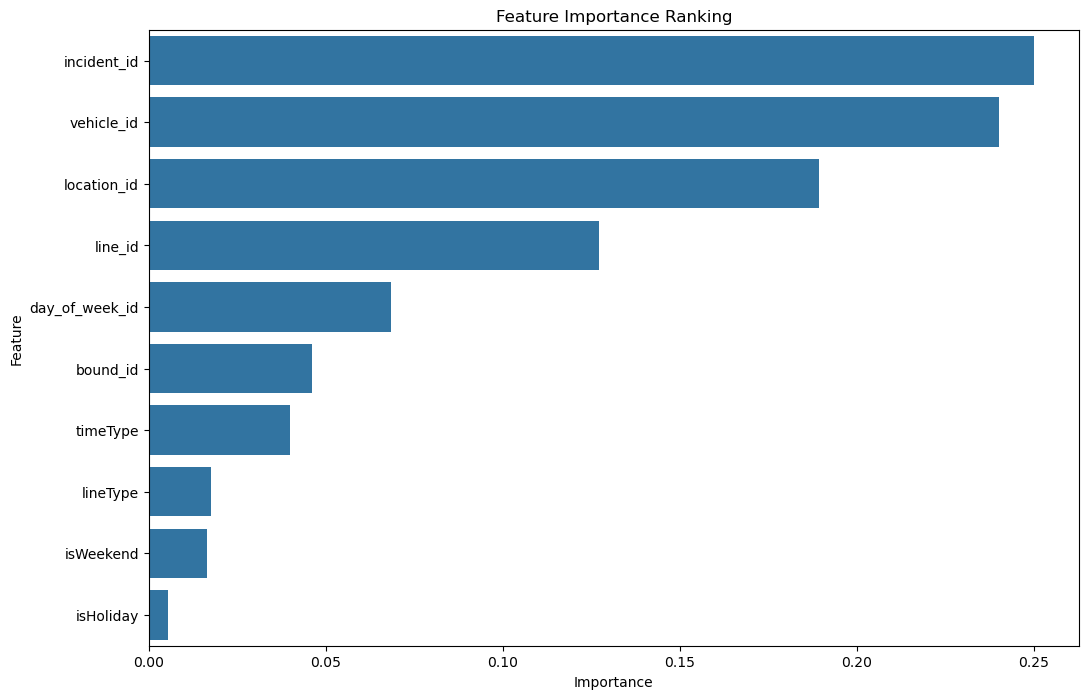

In [48]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The dataframe importance_df contains the 'Feature' and 'Importance' columns

# 1. Feature Importance Graph
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance Ranking')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Interpretation**

* Incident_id and vehicle_id are the most important features, accounting for approximately 25% and 24% respectively, indicating that they have the greatest impact on predicting delay types.
* Location_id and line_id are also relatively important, accounting for approximately 19% and 13% respectively, suggesting that the location of the delay and the line type play significant roles in predicting delay types.
* Day_of_week_id has a moderate impact, contributing about 6.8%, indicating that the day of the week also influences the prediction to some extent.
* Other features such as bound_id, timeType, lineType, isWeekend, and isHoliday have a smaller impact, suggesting that they are less significant for the model.

# 3) Pie Charts for Delay Types Distribution

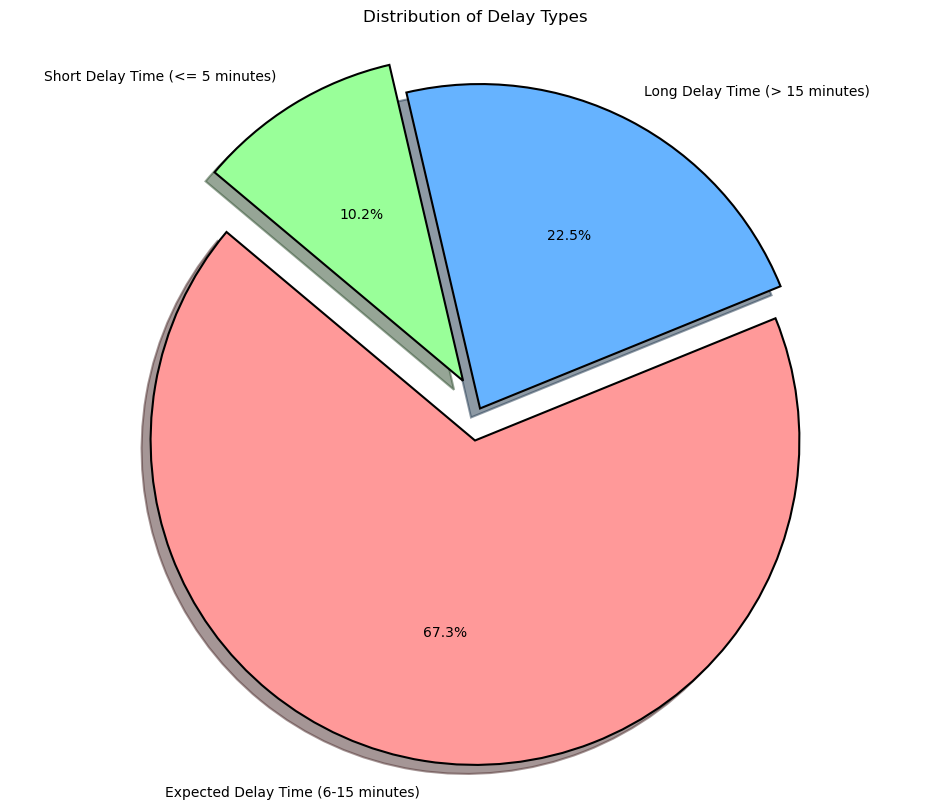

In [49]:
labels = ['Expected Delay Time (6-15 minutes)', 'Long Delay Time (> 15 minutes)', 'Short Delay Time (<= 5 minutes)']
sizes = delay_type_counts.values
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.figure(figsize=(12, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,
         wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}, shadow=True, explode=(0.1, 0, 0.1))
plt.title('Distribution of Delay Types')
plt.axis('equal')
plt.show()

**Interpretation**

* Expected Delay Time (6-15 minutes): This category dominates the dataset, accounting for 67.3% of all delays. This indicates that most delays fall within the expected range of 6 to 15 minutes.
* Long Delay Time (> 15 minutes): This category makes up 22.5% of the delays. Although less frequent compared to the expected delay time, long delays still represent a significant portion of the incidents.
* Short Delay Time (<= 5 minutes): Short delays contribute 10.2% of the total. This is the smallest category, suggesting that delays of 5 minutes or less are relatively uncommon compared to the other types.


# 4) Heatmaps 

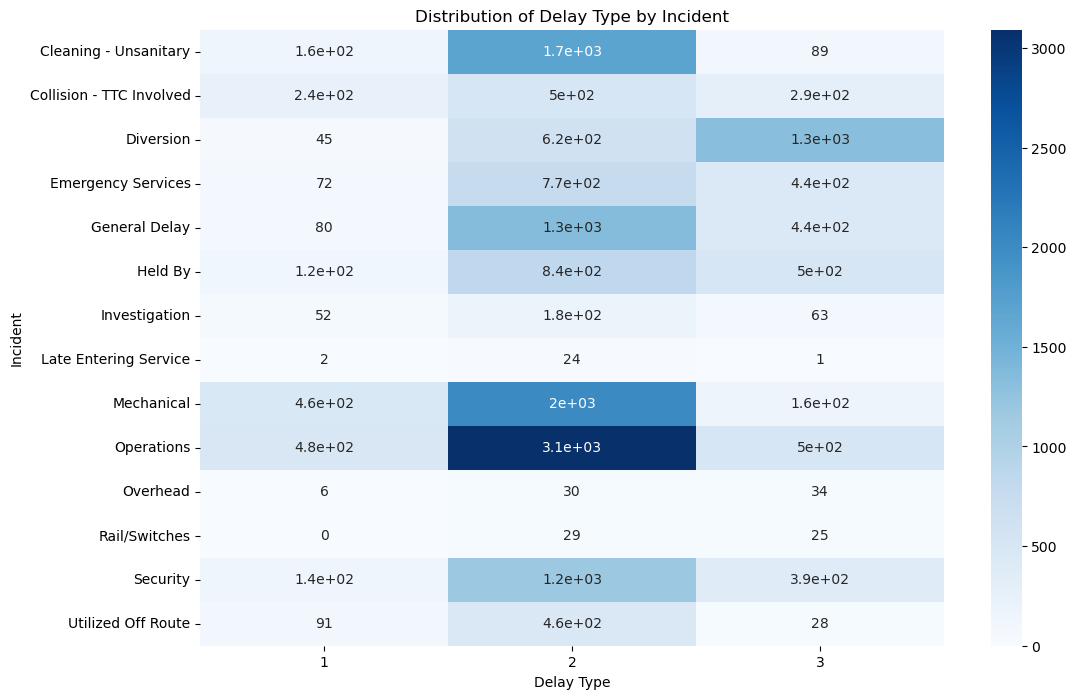

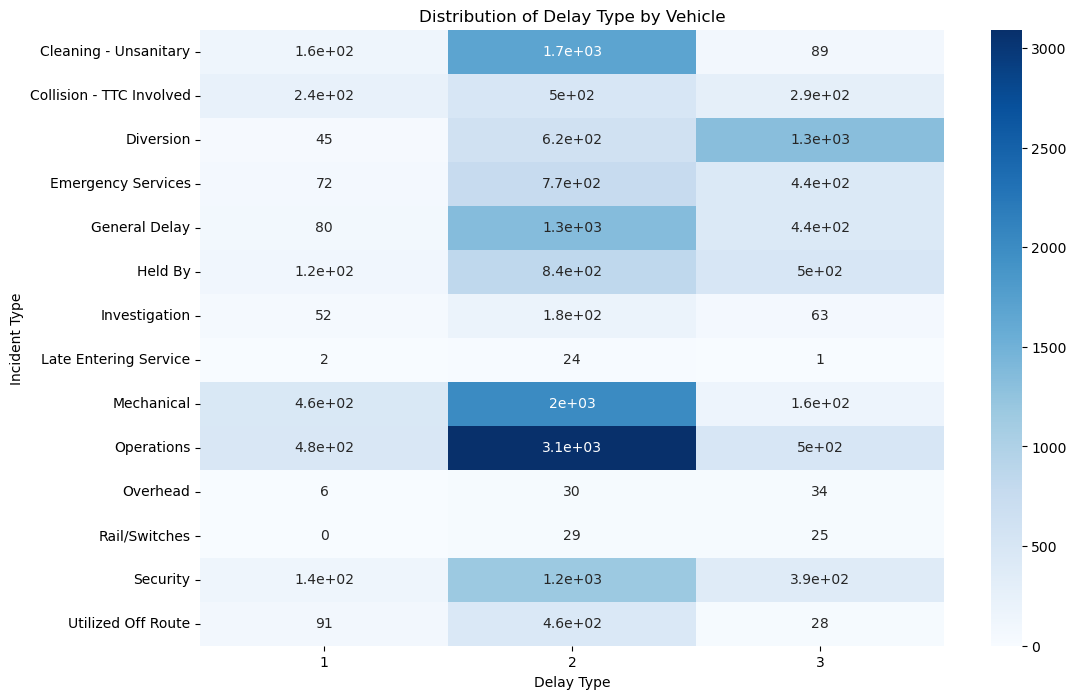

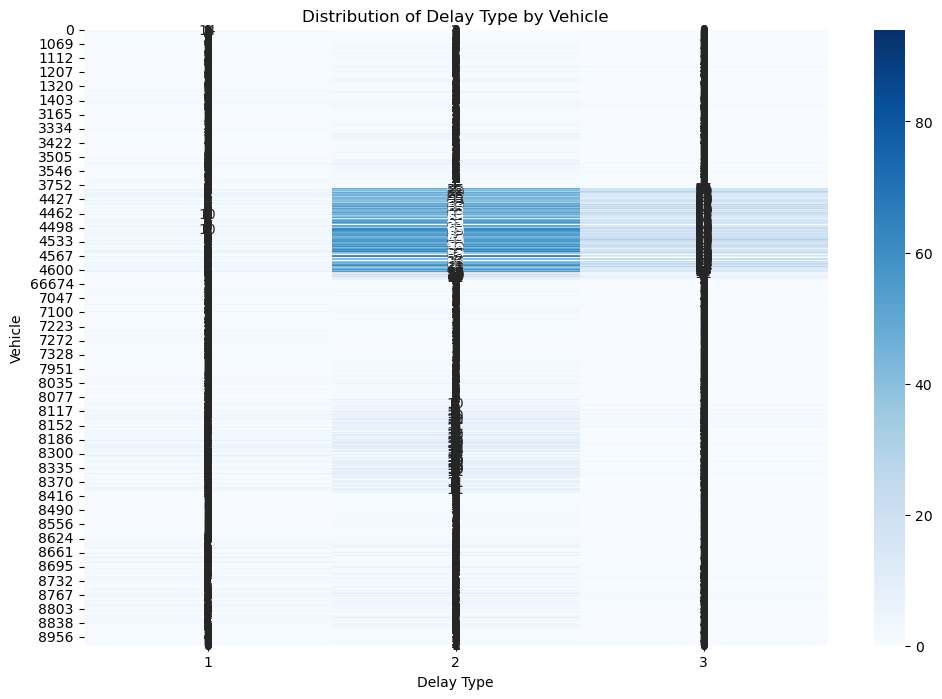

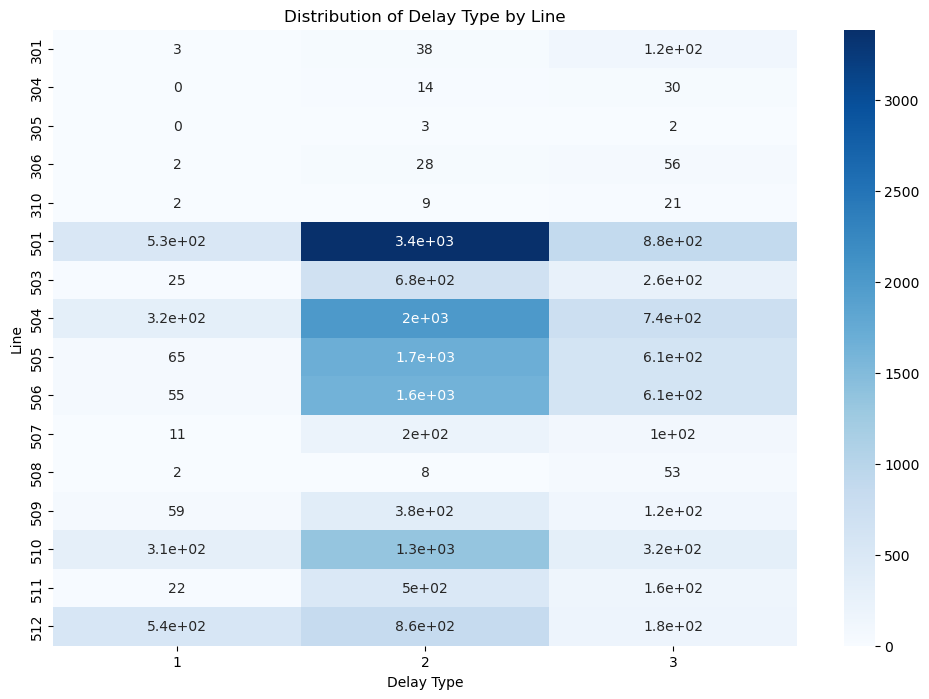

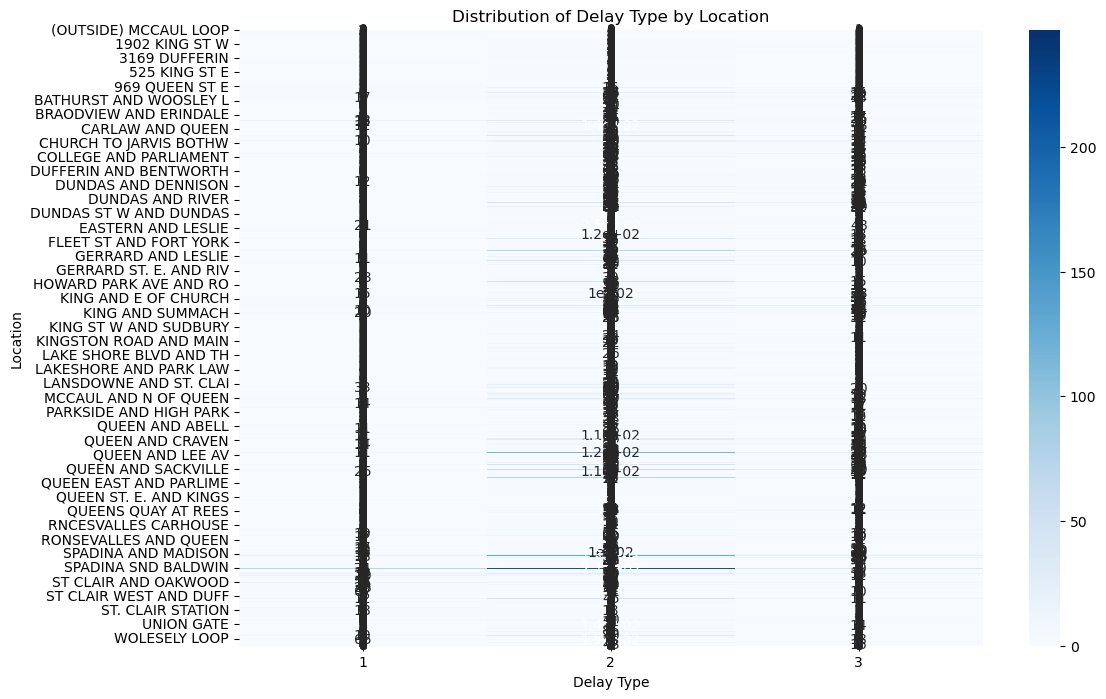

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Analyzing the distribution of delayType for the top feature: incident
incident_delay_type = df_cleaned.groupby(['incident', 'delayType']).size().unstack().fillna(0)
# Plotting the distribution of delayType for incidents
plt.figure(figsize=(12, 8))
sns.heatmap(incident_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Incident')
plt.xlabel('Delay Type')
plt.ylabel('Incident')
plt.show()

# Heatmap for Incident types
vehicle_delay_type = df_cleaned.groupby(['incident', 'delayType']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(vehicle_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Vehicle')
plt.xlabel('Delay Type')
plt.ylabel('Incident Type')
plt.show()

# Heatmap for Vehicles:
vehicle_delay_type = df_cleaned.groupby(['vehicle', 'delayType']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(vehicle_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Vehicle')
plt.xlabel('Delay Type')
plt.ylabel('Vehicle')
plt.show()

# Heatmap for Line (Route)
vehicle_delay_type = df_cleaned.groupby(['line', 'delayType']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(vehicle_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Line')
plt.xlabel('Delay Type')
plt.ylabel('Line')
plt.show()

# Heatmap for Location
vehicle_delay_type = df_cleaned.groupby(['location', 'delayType']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(vehicle_delay_type, annot=True, cmap='Blues')
plt.title('Distribution of Delay Type by Location')
plt.xlabel('Delay Type')
plt.ylabel('Location')
plt.show()


**Interpretation**

* Distribution of Delay Type by Incident: This heatmap visualizes the relationship between different incident types and the delay type. The darker blue areas indicate a higher number of incidents leading to specific delay types. The "Operations" and "Mechanical" incidents are the major contributors to the "Expected Delay Time" (type 2), with the highest counts in that category.

* Distribution of Delay Type by Vehicle: This heatmap shows how different vehicles are associated with delay types. Similar to the incident heatmap, certain vehicles have a higher frequency of delay type 2. The darkest regions indicate that specific vehicles have repeatedly contributed to significant delays, primarily of type 2.

* Distribution of Delay Type by Line: The heatmap shows the relationship between streetcar lines and delay types. Lines like 501 and 504 are the most affected, contributing majorly to delay type 2. It is evident from the darker shades that these lines experience consistent delays, mainly expected delay types.

* Distribution of Delay Type by Location: This heatmap reveals the locations where delays are most frequent. Locations such as "Dundas St W and Dundas" and "Gerrard and Leslie" have been major contributors to delay type 2, represented by the higher counts. The chart shows that specific locations are prone to delays, particularly expected ones.

* Most Dominant Incidents for Delay Type 2: This bar chart highlights the most dominant incident types for delay type 2 (expected delay between 6 and 15 minutes). "Operations" and "Mechanical" incidents are the leading causes, followed by incidents related to "Cleaning - Unsanitary" and "General Delay". This helps in understanding that addressing operations and mechanical issues could help reduce a significant number of expected delays.

# 5) Most dominant incidents for DelayType 2

C:\Users\Xiaoxiao\AppData\Local\Temp\ipykernel_23824\624722970.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Count', y='Incident', data=incident_rankings, palette='viridis')


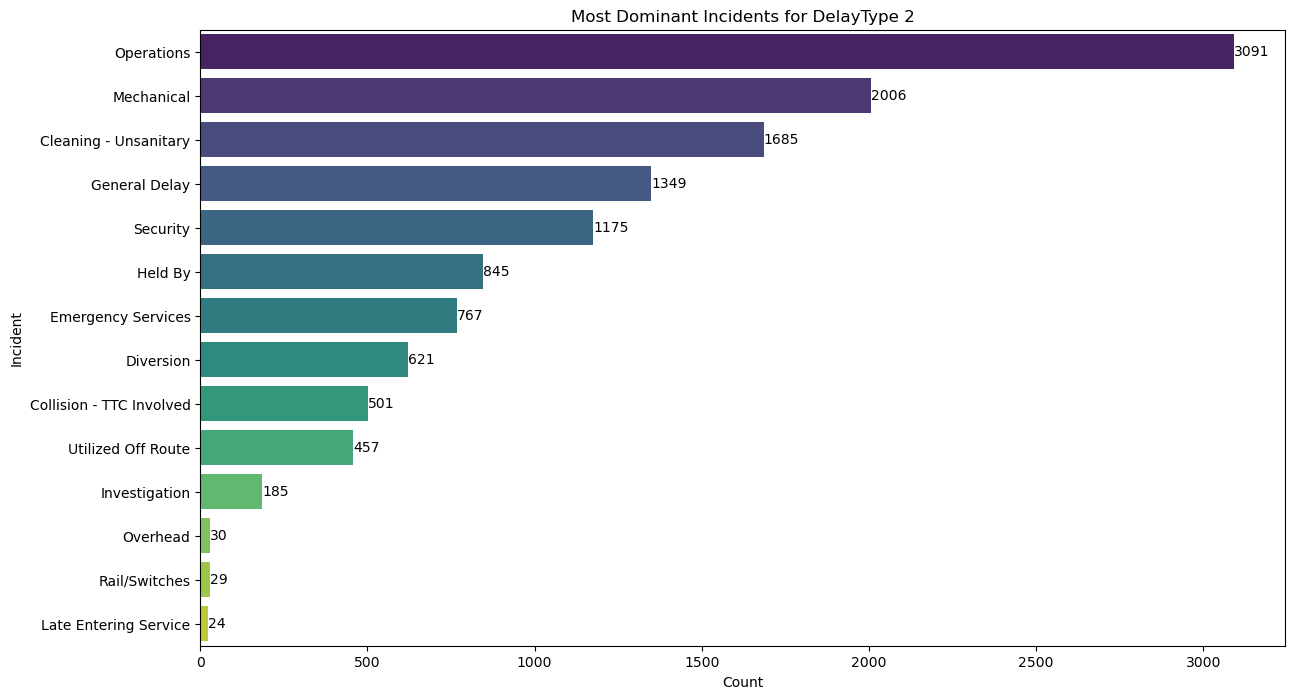

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df_cleaned is your DataFrame
# Filter the DataFrame for delayType 2
delayType_2 = df_cleaned[df_cleaned['delayType'] == 2]
# Group by 'incident' and count the occurrences
incident_counts = delayType_2['incident'].value_counts()
# Create a DataFrame for better visualization
incident_rankings = incident_counts.reset_index()
incident_rankings.columns = ['Incident', 'Count']
# Sort the DataFrame by count in descending order
incident_rankings = incident_rankings.sort_values(by='Count', ascending=False)
# Plotting the bar plot
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='Count', y='Incident', data=incident_rankings, palette='viridis')
# Annotate the bar plot with the count values
for index, value in enumerate(incident_rankings['Count']):
    barplot.text(value, index, str(value), color='black', ha="left", va='center')
plt.title('Most Dominant Incidents for DelayType 2')
plt.xlabel('Count')
plt.ylabel('Incident')
plt.show()

**Interpretation:** 

The bar chart shows the most common incidents contributing to Delay Type 2 (Expected Delay Time: 6-15 minutes). 

* The most significant contributor is Operations incidents, which occur 3091 times, suggesting that operational issues are the primary driver of this delay type. 
* Mechanical incidents follow with 2006 occurrences, indicating that mechanical problems also play a substantial role. 
* Cleaning - Unsanitary issues come next, with 1685 occurrences, highlighting maintenance-related factors.

* This insight implies that focusing on improving operational efficiency and mechanical reliability could significantly reduce the expected delay time of 6-15 minutes. Furthermore, addressing unsanitary conditions could also help decrease delays. These areas should be prioritized for targeted improvements to mitigate Delay Type 2.

<center>

# **CONCLUSION** 

By: Xiaoxiao Gong 

This analysis aims to uncover patterns and significant factors contributing to delays experienced by the TTC streetcar system. Through the use of various visualizations and statistical methods, several insights were derived from the available data. Below is a detailed summary of our findings:

1. **Feature Importance Ranking**:
   The feature importance analysis using the Random Forest model indicates that the primary factors contributing to delays are `incident_id`, `vehicle_id`, `location_id`, and `line_id`. Specifically:
   - `incident_id` and `vehicle_id` are the most influential features, accounting for approximately 25% and 24% of the influence, respectively.
   - `location_id` and `line_id` also have substantial impacts, contributing around 19% and 13%. This suggests that addressing specific incident types and vehicle-related issues could potentially reduce the delays significantly.

2. **Delay Type Distribution**:
   The pie chart of delay type distribution shows that the majority of delays fall under **Expected Delay Time (6-15 minutes)**, making up **67.3%** of all cases. Short delays (<= 5 minutes) and long delays (> 15 minutes) are less frequent, contributing **10.2%** and **22.5%** respectively. This skewed distribution highlights that the streetcar system is more prone to experiencing expected delays rather than extremes, which could be the target area for improvement.

3. **Distribution of Delay Type by Incident**:
   The heatmap analyzing delay type by incident reveals that incidents related to "Operations" and "Mechanical" issues are the leading causes of expected delays (type 2). This is especially evident with the darkest regions in the heatmap representing high frequency. Other notable incidents include "Cleaning - Unsanitary" and "Security", which also contribute significantly to delay types. The focus should thus be on reducing operational inefficiencies and mechanical failures.

4. **Distribution of Delay Type by Vehicle**:
   When assessing the delays caused by specific vehicles, it was evident that certain vehicles have a greater tendency to experience expected delays (type 2). This suggests the need for targeted maintenance or monitoring on specific vehicles to minimize recurring issues.

5. **Distribution of Delay Type by Line**:
   The analysis by streetcar line shows that **line 501** and **line 504** are particularly vulnerable to expected delays. Given the large passenger volume that these lines likely serve, prioritizing these routes for improvements could enhance service reliability for a significant portion of riders.

6. **Distribution of Delay Type by Location**:
   The heatmap for delays by location indicates that specific locations, such as **Dundas St W and Dundas** as well as **Gerrard and Leslie**, are prone to frequent delays. Addressing congestion or operational issues at these high-impact locations could help reduce overall system delays.

7. **Most Dominant Incidents for Delay Type 2**:
   The bar plot of the most dominant incidents for delay type 2 highlights "Operations" and "Mechanical" as the major contributors, with **3091** and **2006** occurrences respectively. Secondary contributors include "Cleaning - Unsanitary" and "General Delay". This implies that a significant number of delays could be mitigated by improving operational planning, fleet maintenance, and cleanliness standards.


From this analysis, it is evident that **Expected Delays (6-15 minutes)** dominate the TTC streetcar system. The primary contributing factors are related to **incidents**, **vehicles**, **locations**, and **specific lines**. Most notably, operational and mechanical issues significantly impact delay times, especially on lines like 501 and 504 and at key locations such as Dundas St W.

To improve the efficiency and reliability of the TTC streetcar service, a targeted strategy focusing on:
- **Reducing Mechanical Failures**: Conducting preventive maintenance more frequently for vehicles prone to delays.
- **Operational Efficiency**: Enhancing operational procedures to prevent incidents.
- **Focus on High-Impact Routes and Locations**: Addressing issues specifically on lines 501, 504, and locations like Dundas St W and Gerrard.
  
These actions could potentially reduce the high frequency of expected delays and enhance the overall experience for TTC streetcar users.

